author: Songyang Cheng

date: 1121

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates
from time import time,localtime,strftime
import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
%matplotlib inline

## Pedestrian Count Distribution on Weekday/Weekends

In [2]:
pedestrian = pd.read_csv('Upper_State_St._Pedestrian_Counts.csv')
names = pedestrian.Time.str.split(' ',expand=True)
names.columns = ['date', 'Hour']
pedestrian = pedestrian.join(names)
pedestrian["date"] = pd.to_datetime(pedestrian["date"])
pedestrian["day_of_week"] = pedestrian["date"].dt.weekday_name
pedestrian["day_of_week"].value_counts()

Friday       1272
Monday       1272
Wednesday    1248
Sunday       1248
Tuesday      1248
Thursday     1247
Saturday     1224
Name: day_of_week, dtype: int64

In [3]:
ped_wkd = pedestrian[(pedestrian['day_of_week'] == 'Monday')|
                     (pedestrian['day_of_week'] == 'Tuesday')|
                     (pedestrian['day_of_week'] == 'Wednesday')|
                     (pedestrian['day_of_week'] == 'Thursday') ]
ped_fri = pedestrian[(pedestrian['day_of_week'] == 'Friday')]
ped_sat = pedestrian[(pedestrian['day_of_week'] == 'Saturday')]
ped_sun = pedestrian[(pedestrian['day_of_week'] == 'Sunday')]

In [4]:
def column_concat_df(wkd, fri, sat, sun, col_name):
    df = pd.concat([wkd[col_name].reset_index(drop=True), 
                    fri[col_name].reset_index(drop=True),
                    sat[col_name].reset_index(drop=True),
                    sun[col_name].reset_index(drop=True)], 
                     axis=1)
    df.columns = ["Weekday", "Friday", "Saturday", "Sunday"]
    return df

In [5]:
def box_plot(df, col_num, title, xlab, ylab, ylim = (0,2000)):
    ax = plt.subplots()[1]
    for i in range(col_num): 
        col = df.columns[i]
        x = i + 1
        y = df[col].quantile(0.5)
        ax.plot(x, y, 'ro')

        # 0.75 to 1 
        y1 = df[col].quantile(0.75)
        y2 = df[col].quantile(1)
        ax.plot((x,x), (y1,y2), 'k')

        # 0.25 to 0 
        y1 = df[col].quantile(0.25)
        y2 = df[col].quantile(0)
        ax.plot((x,x), (y1,y2), 'k')

    ax.set_title(title, fontsize=20)
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels([])
    ax.set_xticks(range(1, len(df.columns)+1))
    ax.set_xlim(0.5, len(df.columns)+0.5)
    ax.set_ylim(ylim)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlabel(xlab, fontsize=16)
    plt.ylabel(ylab, fontsize=16)
    
    return ax

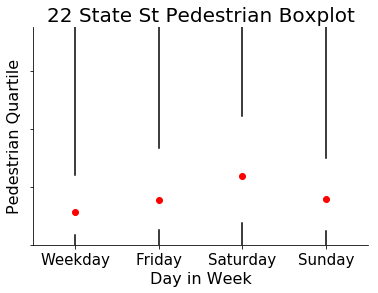

In [6]:
State_22 = column_concat_df(ped_wkd, ped_fri, ped_sat, ped_sun, "SS_22_State_St__North_Side")
box_plot(State_22, 4, "22 State St Pedestrian Boxplot", "Day in Week", "Pedestrian Quartile", (0,750))
None

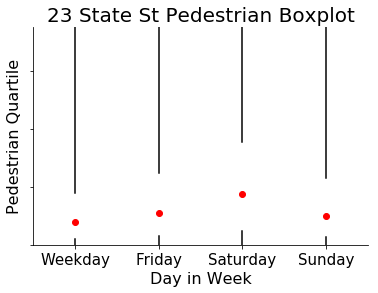

In [7]:
State_23 = column_concat_df(ped_wkd, ped_fri, ped_sat, ped_sun, "SS_23_State_St__South_Side")
box_plot(State_23, 4, "23 State St Pedestrian Boxplot", "Day in Week", "Pedestrian Quartile", (0,750))
None

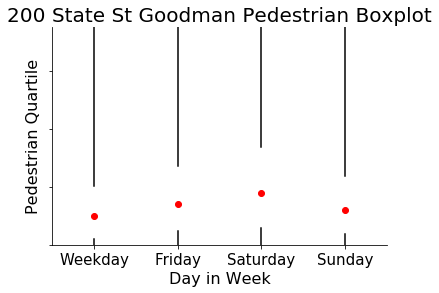

In [8]:
Goodman = column_concat_df(ped_wkd, ped_fri, ped_sat, ped_sun, "F200_State_St____Goodman_s")
box_plot(Goodman, 4, "200 State St Goodman Pedestrian Boxplot", "Day in Week", "Pedestrian Quartile", (0,750))
None

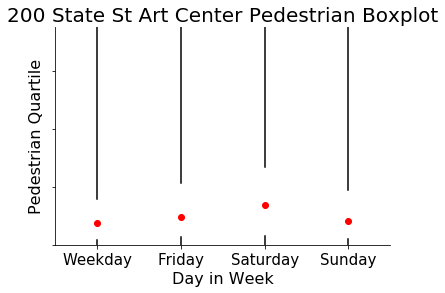

In [9]:
art_center = column_concat_df(ped_wkd, ped_fri, ped_sat, ped_sun, "F200_State_St____Art_Center")
box_plot(art_center, 4, "200 State St Art Center Pedestrian Boxplot", "Day in Week", "Pedestrian Quartile", (0,750))
None

The volume of Pedestrian does not vary too much, because we can see the 3rd quantile is not too much far away from 1st quantile.

## Pedestrian Counter Positions

In [11]:
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close

In [12]:
import gmaps
gmaps.configure(api_key=api_key)

In [13]:
position = pd.DataFrame({
    "no": [1, 2, 6, 10, 9, 11],
    "location": ["SS-22 State St. North Side", "SS-23 State St. South Side", 
                "200 State St. - Goodman's", "200 State St. - Art Center",
                "344 State St.", "341 State St."],
    "longitude": [43.074837, 43.074676, 43.074889, 43.074709, 43.074905, 43.074716],
    "latitude": [-89.387365, -89.387720, -89.388927, -89.389280, -89.391291, -89.391441],
    "loc":[(43.074837,-89.387365), (43.074676,-89.387720), (43.074889,-89.388927),
          (43.074709,-89.389280), (43.074905,-89.391291), (43.074716,-89.391441)]
})
intersection = pd.DataFrame({
    "location": ["State and Dayton", "State and Gorham", "State and Johnson"],
    "loc":[(43.074739,-89.388009), (43.074783,-89.391701), (43.074774,-89.389964)]
})
ped_count_symbol = [
{'no': '1', 'location': (43.074837,-89.387365), 'location': "SS-22 State St. North Side"},
{'no': '2', 'location': (43.074676,-89.387720), 'location': "SS-23 State St. South Side"},
{'no': '6', 'location': (43.074889,-89.388927), 'location': "200 State St. - Goodman's"},
{'no': '10', 'location': (43.074709,-89.389280), 'location': "200 State St. - Art Center"},
{'no': '9', 'location': (43.074905,-89.391291), 'location': "344 State St."},
{'no': '11', 'location': (43.074716,-89.391441), 'location': "341 State St."}
]

In [14]:
#Set up your map
fig = gmaps.figure()

info_box_template = \
"""
<dl>
<dt>NO.</dt><dd>{no}</dd>
<dt>Location</dt><dd>{location}</dd>
</dl>
"""
counter_info = [info_box_template.format(**p) for p in ped_count_symbol]
ped_counter = gmaps.marker_layer(position["loc"], info_box_content=counter_info)

intersect_layer = gmaps.symbol_layer(
intersection["loc"], fill_color='rgba(53, 227, 181, 1)',
stroke_color='rgba(53, 227, 181, 1)', scale=6
)

fig.add_layer(ped_counter)
fig.add_layer(intersect_layer)
fig

Figure(layout=FigureLayout(height='420px'))

Link the data of pedestrian and traffic light. I will combine SS-22/SS-23 State St pedestrian data with Dayton/State traffic light data; 200 State St Art Center/Goodman pedestrian data with Johnson/State traffic light data; 341/344 State St data with Gorham/State traffic light data.

## Pedestrain Flow 

In [15]:
programs = pd.read_excel('te_cycle_data.xlsx', sheet_name='Programs')
patterns = pd.read_excel('te_cycle_data.xlsx', sheet_name='Patterns')
programs['Pattern'] = programs['Pattern'].replace('Flash', 0)
programs['Pattern'].astype('int64')

0     0
1     6
2     3
3     1
4     5
5     1
6     6
7     0
8     6
9     3
10    1
11    5
12    1
13    6
14    0
15    6
16    1
17    5
18    1
19    1
20    3
21    5
22    1
23    6
24    6
25    0
26    6
27    2
28    3
29    2
     ..
66    5
67    4
68    1
69    6
70    6
71    0
72    6
73    2
74    3
75    2
76    1
77    4
78    5
79    4
80    1
81    6
82    6
83    7
84    6
85    0
86    6
87    1
88    6
89    6
90    7
91    6
92    0
93    6
94    1
95    6
Name: Pattern, Length: 96, dtype: int64

In [16]:
combined = pd.merge(programs, patterns, on=['Intersection', 'Pattern'], how="left")
Dayton = combined[combined['Intersection'] == 'State and Dayton']
Gorham = combined[combined['Intersection'] == 'State and Gorham']
Johnson = combined[combined['Intersection'] == 'State and Johnson']

In [17]:
Dayton_weekday = Dayton[Dayton['Day Type'] == 'Monday - Thursday']
Dayton_fri = Dayton[Dayton['Day Type'] == 'Friday']
Dayton_sat = Dayton[Dayton['Day Type'] == 'Saturday']
Dayton_sun = Dayton[Dayton['Day Type'] == 'Sunday']

Johnson_wkd = Johnson[Johnson['Day Type'] == 'Monday - Thursday']
Johnson_fri = Johnson[Johnson['Day Type'] == 'Friday']
Johnson_sat = Johnson[Johnson['Day Type'] == 'Saturday']
Johnson_sun = Johnson[Johnson['Day Type'] == 'Sunday']

Gorham_wkd = Gorham[Gorham['Day Type'] == 'Monday - Thursday']
Gorham_fri = Gorham[Gorham['Day Type'] == 'Friday']
Gorham_sat = Gorham[Gorham['Day Type'] == 'Saturday']
Gorham_sun = Gorham[Gorham['Day Type'] == 'Sunday']

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
def ped_pat(ped_count1, ped_count2, ped_count3, title2):
    fig2 = plt.figure(figsize=(9.5, 5))
    ax2 = fig2.add_subplot(211)
    lines = ax2.plot(ped_count1.index, ped_count1.values, label = "Dayton")
    lines = ax2.plot(ped_count1.index, ped_count2.values, label = "Gorham")
    lines = ax2.plot(ped_count1.index, ped_count3.values, label = "Johnson")
    ax2.set_title(title2, fontsize=20)
    ax2.set_xticklabels(ped_count1.index, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=16)
    ax2.set_ylabel("Pedestrain Count", fontsize=16)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    annot_max(ped_count1.index, ped_count2,ax2)
    plt.legend(loc=[1.02, 0.8])
    plt.show()

In [20]:
def preprocess_ped_lights(ped_, street1, street2, lights_):
    # calculate all pedestrian in the specific street area group by time
    s1 = ped_.groupby(ped_.Hour)[street1].median()
    s2 = ped_.groupby(ped_.Hour)[street2].median()
    ped_total = s1 + s2
    
    # preprocess time 
    modify = lights_['Start Time'].copy()
    modify.reset_index(inplace=True, drop=True)
    modify[len(modify)] =  dt.time(23,59,59)
    
    # Rather than plotting the dt.time() on the x-axis, it could be easier to plot the number of seconds that have elapsed in the day. 
    # Below we use a list comprehension to convert the times into the number of seconds elapsed.
    seconds = [(x.hour * 3600 + x.minute * 60 + x.second) for x in modify]
    main = pd.concat([pd.Series([lights_['Main Street Green (s)'].iloc[-1]]), lights_['Main Street Green (s)']])
    cross = pd.concat([pd.Series([lights_['Cross Street Green (s)'].iloc[-1]]), lights_['Cross Street Green (s)']])
    
    return ped_total, seconds, main, cross

In [21]:
# credit to ImportanceOfBeingErnest@overstackflow
# https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot
def annot_max(x,y, ax=None):
    maxIxVal = np.argmax(y);
    zeroBasedIx = np.argwhere(y.index==maxIxVal).flatten()[0];
    xmax = x[zeroBasedIx];
    ymax = y.max()
    text = "x={:s}, count={:.2f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="-",connectionstyle="arc3,rad=0.1")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.98,0.99), **kw)

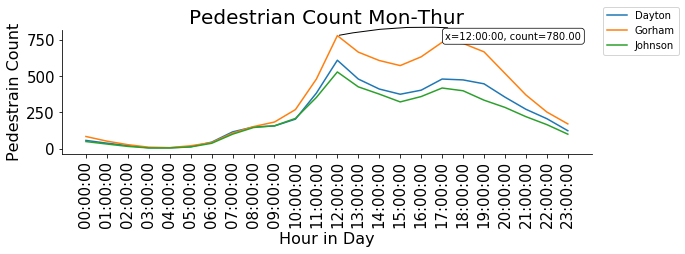

In [22]:
dayton_wkd_total, dayton_wkd_seconds, modify_Dayton_green_main_wkd, modify_Dayton_green_cross_wkd = \
    preprocess_ped_lights(ped_wkd, "SS_22_State_St__North_Side", "SS_23_State_St__South_Side", Dayton_weekday)
johnson_wkd_total, johnson_wkd_seconds, modify_johnson_green_main_wkd, modify_johnson_green_cross_wkd = \
    preprocess_ped_lights(ped_wkd, "F200_State_St____Goodman_s", "F200_State_St____Art_Center", Johnson_wkd)
gorham_wkd_total, gorham_wkd_seconds, modify_gorham_green_main_wkd, modify_gorham_green_cross_wkd = \
    preprocess_ped_lights(ped_wkd, "F341_State_St_", "F344_State_St_", Gorham_wkd)

# ped_pat(dayton_wkd_total, gorham_wkd_total, johnson_wkd_total, "Pedestrian Count Mon-Thur")

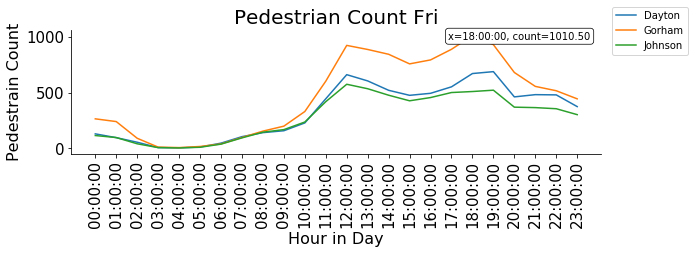

In [23]:
dayton_fri_total, dayton_fri_seconds, modify_Dayton_green_main_fri, modify_Dayton_green_cross_fri = \
    preprocess_ped_lights(ped_fri, "SS_22_State_St__North_Side", "SS_23_State_St__South_Side", Dayton_fri)
johnson_fri_total, johnson_fri_seconds, modify_johnson_green_main_fri, modify_johnson_green_cross_fri = \
    preprocess_ped_lights(ped_fri, "F200_State_St____Goodman_s", "F200_State_St____Art_Center", Johnson_fri)
gorham_fri_total, gorham_fri_seconds, modify_gorham_green_main_fri, modify_gorham_green_cross_fri = \
    preprocess_ped_lights(ped_fri, "F341_State_St_", "F344_State_St_", Gorham_fri)

# ped_pat(dayton_fri_total, gorham_fri_total, johnson_fri_total, "Pedestrian Count Fri")

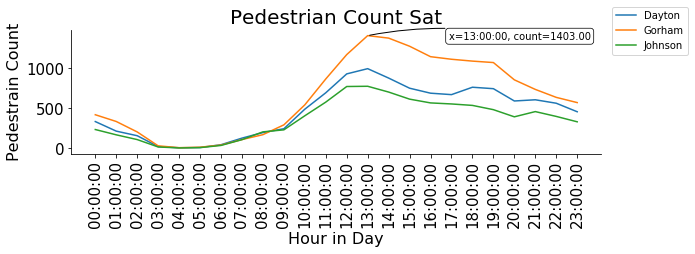

In [24]:
dayton_sat_total, dayton_sat_seconds, modify_Dayton_green_main_sat, modify_Dayton_green_cross_sat = \
    preprocess_ped_lights(ped_sat, "SS_22_State_St__North_Side", "SS_23_State_St__South_Side", Dayton_sat)
johnson_sat_total, johnson_sat_seconds, modify_johnson_green_main_sat, modify_johnson_green_cross_sat = \
    preprocess_ped_lights(ped_sat, "F200_State_St____Goodman_s", "F200_State_St____Art_Center", Johnson_sat)
gorham_sat_total, gorham_sat_seconds, modify_gorham_green_main_sat, modify_gorham_green_cross_sat = \
    preprocess_ped_lights(ped_sat, "F341_State_St_", "F344_State_St_", Gorham_sat)

# ped_pat(dayton_sat_total, gorham_sat_total, johnson_sat_total, "Pedestrian Count Sat")

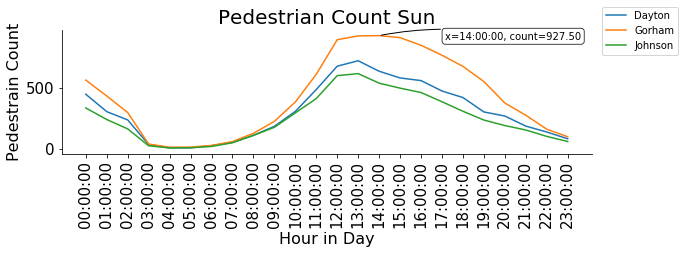

In [25]:
dayton_sun_total, dayton_sun_seconds, modify_Dayton_green_main_sun, modify_Dayton_green_cross_sun = \
    preprocess_ped_lights(ped_sun, "SS_22_State_St__North_Side", "SS_23_State_St__South_Side", Dayton_sun)
johnson_sun_total, johnson_sun_seconds, modify_johnson_green_main_sun, modify_johnson_green_cross_sun = \
    preprocess_ped_lights(ped_sun, "F200_State_St____Goodman_s", "F200_State_St____Art_Center", Johnson_sun)
gorham_sun_total, gorham_sun_seconds, modify_gorham_green_main_sun, modify_gorham_green_cross_sun = \
    preprocess_ped_lights(ped_sun, "F341_State_St_", "F344_State_St_", Gorham_sun)

# ped_pat(dayton_sun_total, gorham_sun_total, johnson_sun_total, "Pedestrian Count Sun")

In [167]:
def ped_pat_total(ped_count1, ped_count2, ped_count3, title1, 
           ped_count10, ped_count20, ped_count30, title2, 
           ped_count100, ped_count200, ped_count300, title3, 
           ped_count1000, ped_count2000, ped_count3000, title4):
    
    fig2 = plt.figure(figsize=(15, 5))
    ax2 = fig2.add_subplot(221)
    lines = ax2.plot(ped_count1.index, ped_count1.values, label = "Dayton")
    lines = ax2.plot(ped_count1.index, ped_count2.values, label = "Gorham")
    lines = ax2.plot(ped_count1.index, ped_count3.values, label = "Johnson")
    ax2.set_title(title1, fontsize=20)
    ax2.set_xticklabels(ped_count1.index, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=16)
    ax2.set_ylabel("Pedestrain Count", fontsize=16)
    ax2.set_ylim(0, 1400)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    annot_max(ped_count1.index, ped_count2,ax2)
    
    ax2 = fig2.add_subplot(222)
    lines = ax2.plot(ped_count10.index, ped_count10.values, label = "Dayton")
    lines = ax2.plot(ped_count10.index, ped_count20.values, label = "Gorham")
    lines = ax2.plot(ped_count10.index, ped_count30.values, label = "Johnson")
    ax2.set_title(title2, fontsize=20)
    ax2.set_xticklabels(ped_count10.index, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=16)
    ax2.set_ylabel("Pedestrain Count", fontsize=16)
    ax2.set_ylim(0, 1400)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    annot_max(ped_count10.index, ped_count20, ax2)
    plt.legend(loc=[1.02, 0.8])
    
    ax3 = fig2.add_subplot(223)
    lines = ax3.plot(ped_count100.index, ped_count100.values, label = "Dayton")
    lines = ax3.plot(ped_count100.index, ped_count200.values, label = "Gorham")
    lines = ax3.plot(ped_count100.index, ped_count300.values, label = "Johnson")
    ax3.set_title(title3, fontsize=20)
    ax3.set_xticklabels(ped_count100.index, rotation=90)
    ax3.set_xlabel("Hour in Day", fontsize=16)
    ax3.set_ylabel("Pedestrain Count", fontsize=16)
    ax3.set_ylim(0, 1400)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    annot_max(ped_count100.index, ped_count200, ax3)
    
    ax4 = fig2.add_subplot(224)
    lines = ax4.plot(ped_count1000.index, ped_count1000.values, label = "Dayton")
    lines = ax4.plot(ped_count1000.index, ped_count2000.values, label = "Gorham")
    lines = ax4.plot(ped_count1000.index, ped_count3000.values, label = "Johnson")
    ax4.set_title(title4, fontsize=20)
    ax4.set_xticklabels(ped_count1000.index, rotation=90)
    ax4.set_xlabel("Hour in Day", fontsize=16)
    ax4.set_ylabel("Pedestrain Count", fontsize=16)
    ax4.set_ylim(0, 1400)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    annot_max(ped_count1000.index, ped_count2000, ax4)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1.35, wspace=0.25)
    
    plt.show()

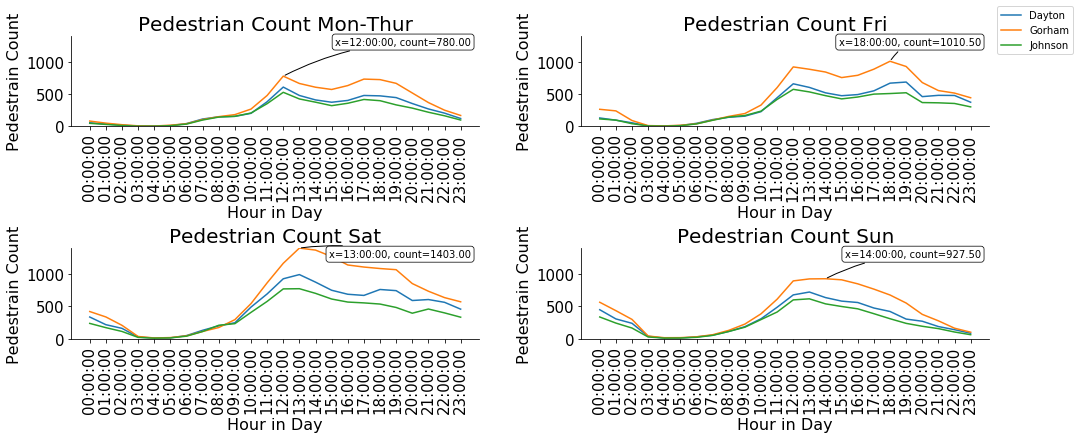

In [168]:
ped_pat_total(
    dayton_wkd_total, gorham_wkd_total, johnson_wkd_total, "Pedestrian Count Mon-Thur", 
    dayton_fri_total, gorham_fri_total, johnson_fri_total, "Pedestrian Count Fri", 
    dayton_sat_total, gorham_sat_total, johnson_sat_total, "Pedestrian Count Sat", 
    dayton_sun_total, gorham_sun_total, johnson_sun_total, "Pedestrian Count Sun")

1. The Pedestrian Count have only one peak around 12 pm - 2 pm on both Saturday and Sunday. However, there are two peaks, one around 12 pm and the other around 6 pm, from Monday to Friday. It can be explained by the commuting.
2. The number of people who walk on Saturday is almost as twice large as the number who walk on weekday (From Monday to Thursday). The number for Friday and Sunday are only 1/3 larger than the number on weekday.

## Green Lights Cycle

In [26]:
pattern_list = ['Pattern', 'Total Cycle Time (s)',
                'Main Street Red (s)', 'Main Street Yellow (s)', 'Main Street Green (s)', 'Main Street Total Cycle Time (s)',
                'Cross Street Red (s)', 'Cross Street Yellow (s)', 'Cross Street Green (s)', 'Cross Street Total Cycle Time (s)']

In [27]:
def constructArr(pat_name, df1, df2=None, df3=None, df4=None):
    length = len(pat_name)/2
    assert length <= 4
    if length == 2:
        assert (df2 is not None)&(df3 is None)&(df4 is None)
    elif length == 3:
        assert (df2 is not None)&(df3 is None)&(df4 is None)
    else:
        assert (df2 is not None)&(df3 is not None)&(df4 is not None)  
    
    if length == 2:
        data = np.array([[float(df1["Main Street Red (s)"]), float(df1['Cross Street Red (s)']), 
                  float(df2["Main Street Red (s)"]), float(df2['Cross Street Red (s)'])], 
                 [float(df1["Main Street Yellow (s)"]), float(df1['Cross Street Yellow (s)']), 
                  float(df2["Main Street Yellow (s)"]), float(df2['Cross Street Yellow (s)'])],
                [float(df1["Main Street Green (s)"]), float(df1['Cross Street Green (s)']), 
                 float(df2["Main Street Green (s)"]), float(df2['Cross Street Green (s)'])]])
        
        percentages = np.array([
                        [float(df1["Main Street Red (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Main Street Yellow (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Main Street Green (s)"]/df1['Total Cycle Time (s)'])*100], 
                        [float(df1["Cross Street Red (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Cross Street Yellow (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Cross Street Green (s)"]/df1['Total Cycle Time (s)'])*100],
                       [float(df2["Main Street Red (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Main Street Yellow (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Main Street Green (s)"]/df2['Total Cycle Time (s)'])*100], 
                        [float(df2["Cross Street Red (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Cross Street Yellow (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Cross Street Green (s)"]/df2['Total Cycle Time (s)'])*100]
                       ])
        y_pos = [0, 0.08, 0.25, 0.33]
    elif length == 4:
        data = np.array([[float(df1["Main Street Red (s)"]), float(df1['Cross Street Red (s)']), 
                  float(df2["Main Street Red (s)"]), float(df2['Cross Street Red (s)']), 
                    float(df3["Main Street Red (s)"]), float(df3['Cross Street Red (s)']), 
                  float(df4["Main Street Red (s)"]), float(df4['Cross Street Red (s)'])], 
                 [float(df1["Main Street Yellow (s)"]), float(df1['Cross Street Yellow (s)']), 
                  float(df2["Main Street Yellow (s)"]), float(df2['Cross Street Yellow (s)']),
                 float(df3["Main Street Yellow (s)"]), float(df3['Cross Street Yellow (s)']), 
                  float(df4["Main Street Yellow (s)"]), float(df4['Cross Street Yellow (s)'])],
                [float(df1["Main Street Green (s)"]), float(df1['Cross Street Green (s)']), 
                 float(df2["Main Street Green (s)"]), float(df2['Cross Street Green (s)']),
                float(df3["Main Street Green (s)"]), float(df3['Cross Street Green (s)']), 
                 float(df4["Main Street Green (s)"]), float(df4['Cross Street Green (s)'])]])
        
        percentages = np.array([
                        [float(df1["Main Street Red (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Main Street Yellow (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Main Street Green (s)"]/df1['Total Cycle Time (s)'])*100], 
                        [float(df1["Cross Street Red (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Cross Street Yellow (s)"]/df1['Total Cycle Time (s)'])*100, 
                         float(df1["Cross Street Green (s)"]/df1['Total Cycle Time (s)'])*100],
                       [float(df2["Main Street Red (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Main Street Yellow (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Main Street Green (s)"]/df2['Total Cycle Time (s)'])*100], 
                        [float(df2["Cross Street Red (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Cross Street Yellow (s)"]/df2['Total Cycle Time (s)'])*100, 
                         float(df2["Cross Street Green (s)"]/df2['Total Cycle Time (s)'])*100], 
                        [float(df3["Main Street Red (s)"]/df3['Total Cycle Time (s)'])*100, 
                         float(df3["Main Street Yellow (s)"]/df3['Total Cycle Time (s)'])*100, 
                         float(df3["Main Street Green (s)"]/df3['Total Cycle Time (s)'])*100], 
                        [float(df3["Cross Street Red (s)"]/df3['Total Cycle Time (s)'])*100, 
                         float(df3["Cross Street Yellow (s)"]/df3['Total Cycle Time (s)'])*100, 
                         float(df3["Cross Street Green (s)"]/df3['Total Cycle Time (s)'])*100],
                       [float(df4["Main Street Red (s)"]/df4['Total Cycle Time (s)'])*100, 
                         float(df4["Main Street Yellow (s)"]/df4['Total Cycle Time (s)'])*100, 
                         float(df4["Main Street Green (s)"]/df4['Total Cycle Time (s)'])*100], 
                        [float(df4["Cross Street Red (s)"]/df4['Total Cycle Time (s)'])*100, 
                         float(df4["Cross Street Yellow (s)"]/df4['Total Cycle Time (s)'])*100, 
                         float(df4["Cross Street Green (s)"]/df4['Total Cycle Time (s)'])*100]
                       ])
        y_pos = [0, 0.08, 0.25, 0.33, 0.5, 0.58, 0.75, 0.83]
        
    return data, percentages, y_pos

In [32]:
def visPattern(pat_name, data, percentages, xlab, title, y_pos, figsize):
    segments = 3
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    colors1 =['red', 'yellow', 'green']
    patch_handles = []
    left = np.zeros(len(pat_name)) # left alignment of data starts at zero

    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y=y_pos, width=d, height=0.05, left=left, color=colors1[i], align='center'))
        # accumulate the left-hand offsets
        left += d

    # go through all of the bar segments and annotate
    for j in range(len(patch_handles)):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, "%.1f%%" % (percentages[i,j]), ha='center')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(pat_name)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_title(title, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

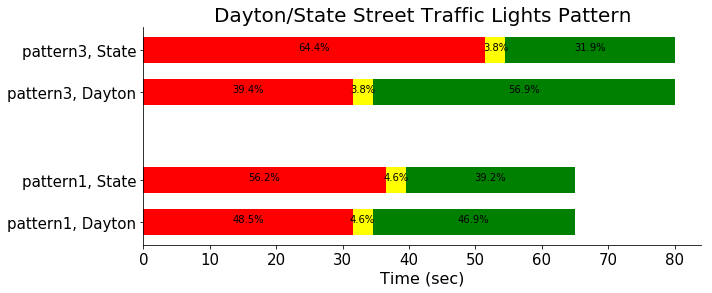

In [33]:
Dayton_cycle = patterns[patterns['Intersection'] == 'State and Dayton']
Dayton_cycle = Dayton_cycle[pattern_list]
Dayton_cycle['Main Street Red (s)'] +=  Dayton_cycle['Cross Street Total Cycle Time (s)']
Dayton_cycle['Cross Street Red (s)'] += Dayton_cycle['Main Street Total Cycle Time (s)']
Dayton_pat = ('pattern1, Dayton', 'pattern1, State', 'pattern3, Dayton', 'pattern3, State')
dayton_data, dayton_pctg, dayton_y = constructArr(Dayton_pat, Dayton_cycle[Dayton_cycle['Pattern'] == 1], 
                                                 Dayton_cycle[Dayton_cycle['Pattern'] == 3])
visPattern(Dayton_pat, dayton_data, dayton_pctg, 'Time (sec)', 
           "Dayton/State Street Traffic Lights Pattern", dayton_y, (10,4) )

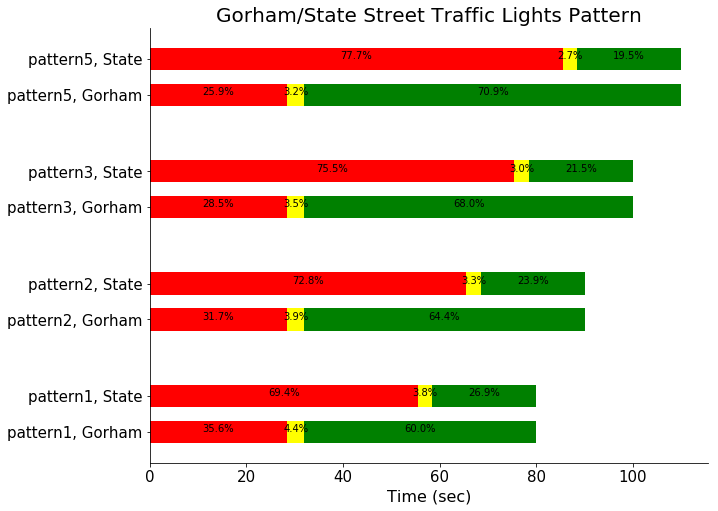

In [34]:
Gorham_cycle = patterns[patterns['Intersection'] == 'State and Gorham']
Gorham_cycle = Gorham_cycle[pattern_list]
Gorham_cycle['Main Street Red (s)'] +=  Gorham_cycle['Cross Street Total Cycle Time (s)']
Gorham_cycle['Cross Street Red (s)'] += Gorham_cycle['Main Street Total Cycle Time (s)']
Gorham_pat = ('pattern1, Gorham', 'pattern1, State', 
              'pattern2, Gorham', 'pattern2, State', 
              'pattern3, Gorham', 'pattern3, State', 
              'pattern5, Gorham', 'pattern5, State')
gorham_data, gorham_pctg, gorham_y = constructArr(Gorham_pat, Gorham_cycle[Gorham_cycle['Pattern'] == 1], 
                                                 Gorham_cycle[Gorham_cycle['Pattern'] == 2], 
                                                  Gorham_cycle[Gorham_cycle['Pattern'] == 3], 
                                                 Gorham_cycle[Gorham_cycle['Pattern'] == 5])
visPattern(Gorham_pat, gorham_data, gorham_pctg, 'Time (sec)', 
           "Gorham/State Street Traffic Lights Pattern", gorham_y, (10, 8) )

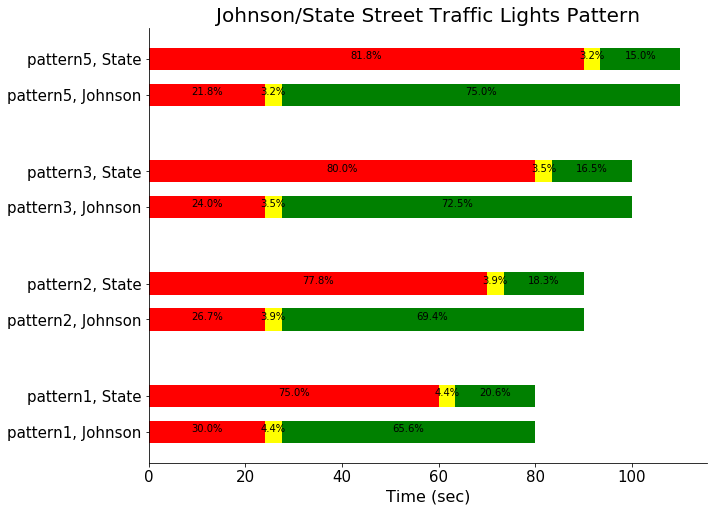

In [35]:
Johnson_cycle = patterns[patterns['Intersection'] == 'State and Johnson']
Johnson_cycle = Johnson_cycle[pattern_list]
Johnson_cycle['Main Street Red (s)'] +=  Johnson_cycle['Cross Street Total Cycle Time (s)']
Johnson_cycle['Cross Street Red (s)'] += Johnson_cycle['Main Street Total Cycle Time (s)']
Johnson_pat = ('pattern1, Johnson', 'pattern1, State', 
              'pattern2, Johnson', 'pattern2, State', 
              'pattern3, Johnson', 'pattern3, State', 
              'pattern5, Johnson', 'pattern5, State')
johnson_data, johnson_pctg, johnson_y = constructArr(Johnson_pat, Johnson_cycle[Johnson_cycle['Pattern'] == 1], 
                                                 Johnson_cycle[Johnson_cycle['Pattern'] == 2], 
                                                  Johnson_cycle[Johnson_cycle['Pattern'] == 3], 
                                                 Johnson_cycle[Johnson_cycle['Pattern'] == 5])
visPattern(Johnson_pat, johnson_data, johnson_pctg, 'Time (sec)', 
           "Johnson/State Street Traffic Lights Pattern", johnson_y, (10, 8) )

For pedestrian to go across Main Street (Dayton, Gorham, or Johnson), they have to wait for a long time. The time they wait is about three to even four times than the other way around.

## Relationship between Light Pattern, Pedestrian and Traffic

In [37]:
# If the number of seconds elapsed is divisible by 1800 (30 minutes), that number will be used as one of the ticks.
# xticks = [x for x in range(60 * 60 * 24 + 30) if x % 1800 == 0]
xticks = [x for x in range(60 * 60 * 24 + 30) if x % 3600 == 0]
xticklabels = [str(dt.timedelta(seconds=x)) for x in xticks]

In [46]:
# bigger arrow
# credit to daronjp@stackoverflow 
# https://stackoverflow.com/questions/58070901/bar-plot-with-24-hours-in-the-x-axis-with-date-time-data-of-only-the-beginning-o
def lights_ped_traffic(timeline, main_gree, cross_green, title1, ped_count, title2, 
                       traffic, traffic_cross, title3,
              street1_lab="Main Street green lights", street2_lab="State Street green lights", 
               arw_x=0.17, arw_y=0.14, flash=True):
    
    fig, ax = plt.subplots(figsize=(10,3))
    
    bar_start = 0
    for ix, (second, main_green, cross_green) in enumerate(zip(timeline, main_gree, cross_green)):
        width = second - bar_start
        ax.bar(bar_start, main_green, width=width, align='edge', color='springgreen', edgecolor='whitesmoke', 
               label=street1_lab if ix == 0 else "_nolegend_")
        ax.bar(bar_start, cross_green, width=width, bottom=main_green, 
               align='edge', color = 'turquoise', edgecolor='whitesmoke', label=street2_lab if ix == 0 else "_nolegend_")
        bar_start += width

    if flash:
        bbox_props = dict(boxstyle="darrow,pad=0.3",lw=2, facecolor="yellow", ec="black")
        txt = ax.text(arw_x, arw_y, "Yellow Flashing", ha="center", va="center", rotation=0,
            size=12, bbox=bbox_props, transform = ax.transAxes)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_title(title1, fontsize=20)
    ax.set_xlabel("Hour in Day", fontsize=16)
    ax.set_ylabel("Time for Green (sec)", fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc=[1.02, 0.8])
    plt.show()

    fig2 = plt.figure(figsize=(9.5, 3))
    ax2 = fig2.add_subplot(211)
#     ax2 = axes[0]
    lines = ax2.plot(ped_count.index, ped_count.values)
    ax2.set_title(title2, fontsize=20)
    ax2.set_xticklabels(ped_count.index, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=16)
    ax2.set_ylabel("Pedestrain Count", fontsize=16)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    annot_max(ped_count.index, ped_count, ax2)
    
    fig3 = plt.figure(figsize=(9.5, 3))
    ax3 = fig3.add_subplot(211)
    ax3.plot(ped_count.index, traffic.values, label="Dayton St")
    ax3.plot(ped_count.index, traffic_cross.values, label="State St")
    ax3.set_title(title3, fontsize=20)
    ax3.set_xticklabels(ped_count.index, rotation=90)  # not an error here, make sure the xticklabels are the same 
    ax3.set_xlabel("Hour in Day", fontsize=16)
    ax3.set_ylabel("Traffic Count", fontsize=16)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    plt.legend(loc=[1.02, 0.8])
    plt.show()

In [40]:
dayton_traffic = pd.read_excel('dayton_traffic.xlsx', sheet_name='Dayton')
dayton_traffic['Sum'] = dayton_traffic.Direction1 + dayton_traffic.Direction2
state_traffic = pd.read_excel('dayton_traffic.xlsx', sheet_name='State')
state_traffic['Sum'] = state_traffic.Direction1 + state_traffic.Direction2

In year 2017-2018, the average daily traffic volume:

Dayton: 11100

State St: 1450

adjust the data set accordingly

In [41]:
dayton_traffic_scale = dayton_traffic/ dayton_traffic.Sum.sum() * 11100
state_traffic_scale = state_traffic/ state_traffic.Sum.sum() * 1450
dayton_traffic_scale = dayton_traffic_scale.applymap(round)
state_traffic_scale = state_traffic_scale.applymap(round)
dayton_traffic_scale['sec/car'] = 3600/dayton_traffic_scale['Sum']
state_traffic_scale['sec/car'] = 3600/state_traffic_scale['Sum']

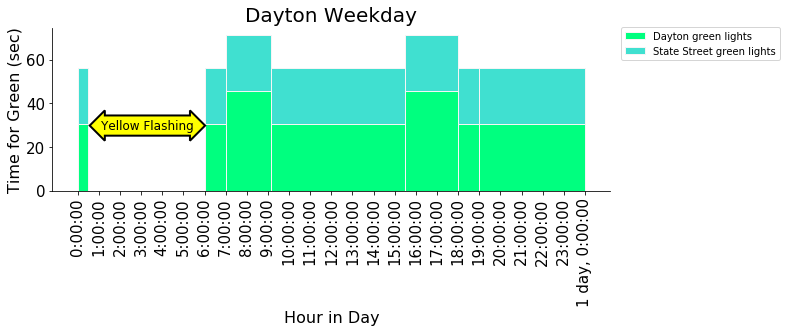

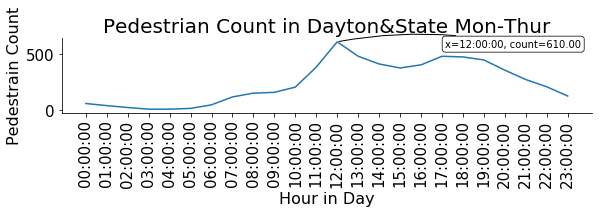

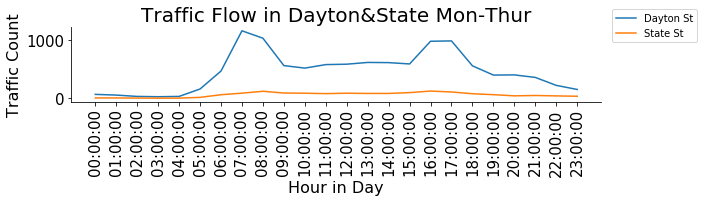

In [47]:
lights_ped_traffic(dayton_wkd_seconds, modify_Dayton_green_main_wkd, modify_Dayton_green_cross_wkd, "Dayton Weekday",
           dayton_wkd_total, "Pedestrian Count in Dayton&State Mon-Thur", 
           dayton_traffic_scale['Sum'], state_traffic_scale['Sum'], "Traffic Flow in Dayton&State Mon-Thur", 
          "Dayton green lights", "State Street green lights", 0.17, 0.4)

1. Light cycle are too long, should adopt shorter and more frequent cycle pattern. 
2. Pattern does not align with morning peak (6 - 8 am). 

## Metric and Optimization

Assumptions:
1. 2/5 pedestrians will go across both Main Street and Cross Street, 2/5 pedestrians will only go across Main Street (go along State Street),
    1/5 pedestrians will go across only State Street. 
  As a result, 4/5 pedestrains will wait for Main Street Red Light, and 3/5 pedestrians will wait for Cross Street Red Light. 
2. Define anger index = 1/3000*(waiting time)^2
3. Every car will pass the intersection in 2 seconds.
4. Pedestrian and Cars come in a constant speed. Uniformly distributed according to time. 

Choose only one intersection as an example to demonstrate. (Dayton/State St on Mon-Thur)

In [71]:
import math
from scipy.optimize import minimize

In [54]:
s22_wkd_sum = ped_wkd.groupby(ped_wkd.Hour)["SS_22_State_St__North_Side"].sum()
s23_wkd_sum = ped_wkd.groupby(ped_wkd.Hour)["SS_23_State_St__South_Side"].sum()
dayton_wkd_sum = s22_wkd_sum + s23_wkd_sum

s22_fri_sum = ped_fri.groupby(ped_fri.Hour)["SS_22_State_St__North_Side"].sum()
s23_fri_sum = ped_fri.groupby(ped_fri.Hour)["SS_23_State_St__South_Side"].sum()
dayton_fri_sum = s22_fri_sum + s23_fri_sum

s22_sat_sum = ped_sat.groupby(ped_sat.Hour)["SS_22_State_St__North_Side"].sum()
s23_sat_sum = ped_sat.groupby(ped_sat.Hour)["SS_23_State_St__South_Side"].sum()
dayton_sat_sum = s22_sat_sum + s23_sat_sum

s22_sun_sum = ped_sun.groupby(ped_sun.Hour)["SS_22_State_St__North_Side"].sum()
s23_sun_sum = ped_sun.groupby(ped_sun.Hour)["SS_23_State_St__South_Side"].sum()
dayton_sun_sum = s22_sun_sum + s23_sun_sum

In [57]:
def compare(ped_idx, cycle):
    if int(ped_idx[:2]) < cycle.hour:
        return -1
    elif int(ped_idx[:2]) == cycle.hour and int(ped_idx[3:5]) < cycle.minute:
        return -1
    elif int(ped_idx[:2]) == cycle.hour and int(ped_idx[3:5]) == cycle.minute:
        return 0
    else:
        return 1

In [55]:
## TODO: Known bugs: if the first start time is not 00:00, it does not adopt the pattern last used
def calc_wait(lights, peds):
    waitTime = []
    start_time = lights['Start Time'].reset_index(drop=True)
    pat = lights.Pattern.reset_index(drop=True)
    for i in range(24):
        for j in range(len(start_time)-1, -1, -1):
            cmp = compare(peds.index[i], start_time[j])
            if cmp > 0:
                waitTime.append(pat[j])
                break
        
    waitTime.append(waitTime[-1])
    waitTime_series = pd.Series(waitTime)
#     print("wt", waitTime)
#     print("index", peds.index)
    waitTime_series = pd.Series(waitTime, index=peds.index)
    return waitTime_series

In [58]:
wt_dayton_wkd = calc_wait(Dayton_weekday, dayton_wkd_sum)
wt_dayton_fri = calc_wait(Dayton_fri, dayton_fri_sum)

In [75]:
def cost_dayton_wkd_tap(redTimeList):
    red_main, red_cross = np.split(redTimeList, 2)  # extract two variables from the whole list
    total_cycle = red_cross + red_main - 3
    ped_count = dayton_wait_wkd.Count[6:].reset_index(drop=True)  # calculate how many pedestrian at that time
    traffic_dayton = dayton_traffic_scale['Sum'][6:].reset_index(drop=True)
    traffic_state = state_traffic_scale['Sum'][6:].reset_index(drop=True)
    count_dayton = dayton_traffic_scale['sec/car'][6:].reset_index(drop=True)
    count_state = state_traffic_scale['sec/car'][6:].reset_index(drop=True)
    assert(len(red_main) == len(red_cross))  # should be equal to 24 if no yellow flashing
    leng = len(red_main)
    
    cost = 0
    for i in range(leng):
        # calculate pedestrian average wait time
        ped_wait_main_avg = red_main[i]**2/(2*total_cycle[i])/3600
        ped_wait_cross_avg = red_cross[i]**2/(2*total_cycle[i])/3600
        ped_wait_main = (ped_count[i]*3/5 * ped_wait_main_avg)
        ped_wait_cross = (ped_count[i]*4/5 * ped_wait_cross_avg)
        
        # calculate traffic average wait time
        count_main = math.ceil(red_main[i]/count_dayton[i])
        count_cross = math.ceil(red_cross[i]/count_state[i])
        tfc_wait_main = (red_main[i]*2 - (count_main-1) * count_dayton[i]) * count_main / 2 # Summation of arithmetic series
        tfc_wait_cross = (red_cross[i]*2 - (count_cross-1) * count_state[i]) * count_cross / 2
        
        # deal with the situation where car need to wait for more than one cycle
        # (red_main/cross[i] - 6) represent the green time in other direction (cross/main respectively)
        count_main_green = math.ceil((red_cross[i] - 6)/count_dayton[i])
        main_extra = 0
        if 2 * (count_main_green+count_main) > (red_cross[i] - 6):
            main_extra = 1000000
        
        count_cross_green = math.ceil((red_main[i] - 6)/count_state[i])
        cross_extra = 0
        if 2 * (count_cross_green+count_cross) > (red_main[i] - 6):
            cross_extra = 1000000
#         tfc_wait_main /= 3600
#         tfc_wait_cross /= 3600  # convert to hour
        
        cost += ped_wait_main**2/3000 + ped_wait_cross**2/3000  #  "/3000" is weight for pedestrian 
        cost += tfc_wait_main**2/100 + tfc_wait_cross**2/100  #  "/100" is weight for pedestrian 
        cost += main_extra + cross_extra
        
#         print(i,  ped_wait_main**2/3000, tfc_wait_main**2/100)
#         print(i,  ped_wait_cross**2/3000, tfc_wait_cross**2/100)
    
    return cost

In [50]:
def construct_ped_wait(ped, wt, cycle, main_coef=3/5, cross_coef=4/5):
    tmp = pd.concat([ped, wt], axis=1)
    tmp['Hour'] = tmp.index
    tmp.columns = ['Count','Pattern','Hour']

    wait_ =  pd.merge(tmp, cycle, on=['Pattern'], how="left")
    wait_['total_wait_main'] = wait_['avg_wait_main']*wait_.Count*main_coef
    wait_['total_wait_cross'] = wait_['avg_wait_cross']*wait_.Count*cross_coef
    
    wait_['avg_wait_main'] = wait_['avg_wait_main'].fillna(0)
    wait_['avg_wait_cross'] = wait_['avg_wait_cross'].fillna(0)
    wait_['total_wait_main'] = wait_['total_wait_main'].fillna(0)
    wait_['total_wait_cross'] = wait_['total_wait_cross'].fillna(0)
    
    return wait_

In [63]:
Dayton_cycle.tail()

,Pattern,Total Cycle Time (s),Main Street Red (s),Main Street Yellow (s),Main Street Green (s),Main Street Total Cycle Time (s),Cross Street Red (s),Cross Street Yellow (s),Cross Street Green (s),Cross Street Total Cycle Time (s)
0,1,65,31.5,3.0,30.5,35,36.5,3.0,25.5,30
1,3,80,31.5,3.0,45.5,50,51.5,3.0,25.5,30
2,5,80,31.5,3.0,45.5,50,51.5,3.0,25.5,30
3,6,65,31.5,3.0,30.5,35,36.5,3.0,25.5,30


In [64]:
Dayton_cycle['avg_wait_main'] = Dayton_cycle['Main Street Red (s)']*Dayton_cycle['Main Street Red (s)']\
    /(2*Dayton_cycle['Total Cycle Time (s)'])
Dayton_cycle['avg_wait_cross'] = Dayton_cycle['Cross Street Red (s)']*Dayton_cycle['Cross Street Red (s)']\
    /(2*Dayton_cycle['Total Cycle Time (s)'])

dayton_wait_wkd = construct_ped_wait(dayton_wkd_sum, wt_dayton_wkd, Dayton_cycle)
dayton_wait_fri = construct_ped_wait(dayton_fri_sum, wt_dayton_fri, Dayton_cycle)
# dayton_wait_sat = construct_ped_wait(dayton_sat_sum, wt_dayton_sat, Dayton_cycle)
# dayton_wait_sun = construct_ped_wait(dayton_sun_sum, wt_dayton_sun, Dayton_cycle)

In [76]:
WT_dayton_wkd = np.concatenate((np.array(dayton_wait_wkd['Main Street Red (s)'])[6:], 
                                np.array(dayton_wait_wkd['Cross Street Red (s)'])[6:]))
cost_dayton_wkd_tap(WT_dayton_wkd)

1002755.566025414

In [73]:
bound = (20, 50)  # every red time must be with in [20, 50] second bounds 
bnds_18 = []
for itr in range(18*2):
    bnds_18.append(bound)
bnds_18 = tuple(bnds_18)
len(bnds_18)

36

In [77]:
res_dayton_wkd_tap = minimize(cost_dayton_wkd_tap, WT_dayton_wkd, method='SLSQP', 
               bounds=bnds_18, options={'xtol': 1e-8, 'disp': True})
res_dayton_wkd_tap.x

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1000821.2486515708
            Iterations: 41
            Function evaluations: 1667
            Gradient evaluations: 40


array([20.000445  , 20.        , 20.        , 20.00128179, 20.00835812,
       20.00029022, 20.04388422, 20.00073563, 20.00005036, 20.00951603,
       20.00167946, 20.        , 20.00120265, 21.80322792, 21.3158893 ,
       21.70252838, 25.68736013, 26.0489155 , 33.0192869 , 39.92023902,
       39.0200504 , 32.41022462, 30.18178349, 29.19597756, 26.93956652,
       28.02337129, 30.06143947, 34.53187397, 36.00029305, 34.00000185,
       28.60345019, 28.50978307, 30.2226746 , 31.54034908, 32.48621307,
       33.51231964])

In [78]:
tmp_list = list(np.around(res_dayton_wkd_tap.x) )
dayton_wkd_tap_main_red = tmp_list[:18]
dayton_wkd_tap_cross_red = tmp_list[18:]
for i in range(len(dayton_wkd_tap_main_red)):
    print("at ", (i+6), ", main red time is ", dayton_wkd_tap_main_red[i], ", cross red time is ", dayton_wkd_tap_cross_red[i])

at  6 , main red time is  20.0 , cross red time is  33.0
at  7 , main red time is  20.0 , cross red time is  40.0
at  8 , main red time is  20.0 , cross red time is  39.0
at  9 , main red time is  20.0 , cross red time is  32.0
at  10 , main red time is  20.0 , cross red time is  30.0
at  11 , main red time is  20.0 , cross red time is  29.0
at  12 , main red time is  20.0 , cross red time is  27.0
at  13 , main red time is  20.0 , cross red time is  28.0
at  14 , main red time is  20.0 , cross red time is  30.0
at  15 , main red time is  20.0 , cross red time is  35.0
at  16 , main red time is  20.0 , cross red time is  36.0
at  17 , main red time is  20.0 , cross red time is  34.0
at  18 , main red time is  20.0 , cross red time is  29.0
at  19 , main red time is  22.0 , cross red time is  29.0
at  20 , main red time is  21.0 , cross red time is  30.0
at  21 , main red time is  22.0 , cross red time is  32.0
at  22 , main red time is  26.0 , cross red time is  32.0
at  23 , main red 

In [104]:
def lights_cmp(timeline, main_gree, cross_green, main_green_opt, cross_green_opt, ped_count, 
                traffic, traffic_cross, title1, title2, title3, title4, 
              street1_lab="Main Street green lights", street2_lab="State Street green lights", 
               arw_x=0.17, arw_y=0.14, flash=True):
    fig, ax = plt.subplots(figsize=(10,3))
    
    bar_start = 0
    for ix, (second, main_green, cross_green) in enumerate(zip(timeline, main_gree, cross_green)):
        width = second - bar_start
        ax.bar(bar_start, main_green, width=width, align='edge', color='springgreen', edgecolor='whitesmoke', 
               label=street1_lab if ix == 0 else "_nolegend_")
        ax.bar(bar_start, cross_green, width=width, bottom=main_green, 
               align='edge', color = 'turquoise', edgecolor='whitesmoke', label=street2_lab if ix == 0 else "_nolegend_")
        bar_start += width

    if flash:
        bbox_props = dict(boxstyle="darrow,pad=0.3",lw=2, facecolor="yellow", ec="black")
        txt = ax.text(arw_x, arw_y, "Yellow Flashing", ha="center", va="center", rotation=0,
            size=12, bbox=bbox_props, transform = ax.transAxes)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_title(title1, fontsize=20)
    ax.set_xlabel("Hour in Day", fontsize=16)
    ax.set_ylabel("Time for Green (sec)", fontsize=16)
    ax.set_ylim(0, 70)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc=[1.02, 0.8])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10,3))
    
    bar_start = 0
    for ix, (second, main_green, cross_green) in enumerate(zip(timeline, main_green_opt, cross_green_opt)):
        width = second - bar_start
        ax.bar(bar_start, main_green, width=width, align='edge', color='springgreen', edgecolor='whitesmoke', 
               label=street1_lab if ix == 0 else "_nolegend_")
        ax.bar(bar_start, cross_green, width=width, bottom=main_green, 
               align='edge', color = 'turquoise', edgecolor='whitesmoke', label=street2_lab if ix == 0 else "_nolegend_")
        bar_start += width

    if flash:
        bbox_props = dict(boxstyle="darrow,pad=0.3",lw=2, facecolor="yellow", ec="black")
        txt = ax.text(arw_x, arw_y, "Yellow Flashing", ha="center", va="center", rotation=0,
            size=12, bbox=bbox_props, transform = ax.transAxes)

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90)
    ax.set_title(title2, fontsize=20)
    ax.set_xlabel("Hour in Day", fontsize=16)
    ax.set_ylabel("Time for Green (sec)", fontsize=16)
    ax.set_ylim(0, 70)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(loc=[1.02, 0.8])
    plt.show()
    
    fig2 = plt.figure(figsize=(9.5, 3))
    ax2 = fig2.add_subplot(211)
    tmp1 = (ped_count.values)*0.6
    tmp2 = (ped_count.values)*0.8
    ax2.plot(ped_count.index, tmp1, label="Dayton St")
    ax2.plot(ped_count.index, tmp2, label="State St")
#     lines = ax2.plot(ped_count.index, ped_count.values)
    ax2.set_title(title3, fontsize=20)
    ax2.set_xticklabels(ped_count.index, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=16)
    ax2.set_ylabel("Pedestrain Count", fontsize=16)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.legend(loc=[1.02, 0.8])
#     annot_max(ped_count.index, ped_count, ax2)
    
    fig3 = plt.figure(figsize=(9.5, 3))
    ax3 = fig3.add_subplot(211)
    ax3.plot(ped_count.index, traffic.values, label="Dayton St")
    ax3.plot(ped_count.index, traffic_cross.values, label="State St")
    ax3.set_title(title4, fontsize=20)
    ax3.set_xticklabels(ped_count.index, rotation=90)  # not an error here, make sure the xticklabels are the same 
    ax3.set_xlabel("Hour in Day", fontsize=16)
    ax3.set_ylabel("Traffic Count", fontsize=16)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    plt.legend(loc=[1.02, 0.8])
    plt.show()

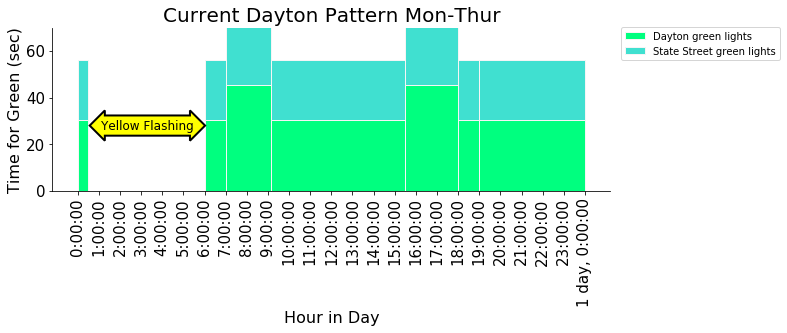

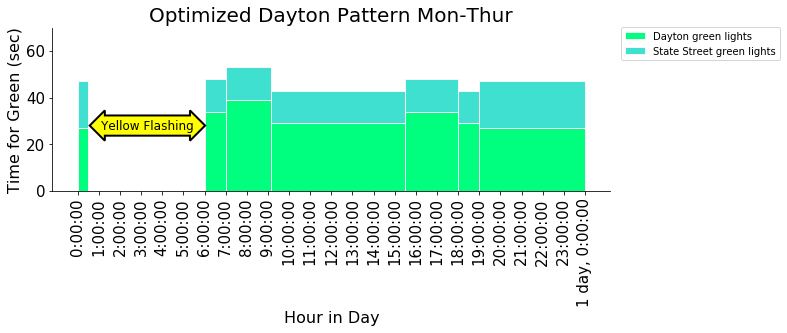

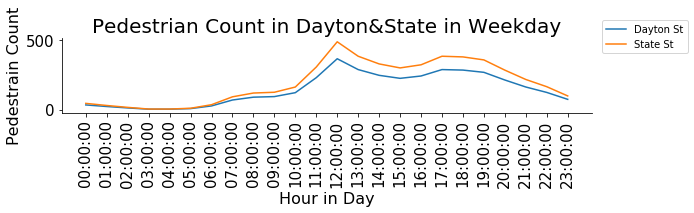

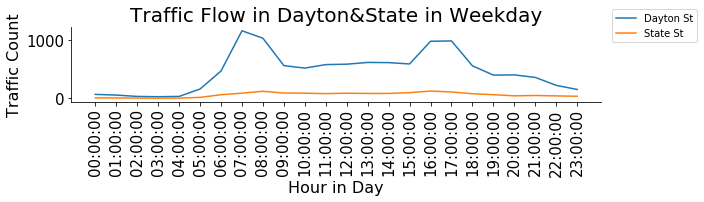

In [105]:
dayton_wkd_total, dayton_wkd_seconds, modify_Dayton_green_main_wkd, modify_Dayton_green_cross_wkd = \
    preprocess_ped_lights(ped_wkd, "SS_22_State_St__North_Side", "SS_23_State_St__South_Side", Dayton_weekday)
dayton_wkd_total_tap, dayton_wkd_seconds_tap, modify_Dayton_green_main_wkd_tap, modify_Dayton_green_cross_wkd_tap = \
    preprocess_ped_lights(ped_wkd, "SS_22_State_St__North_Side", "SS_23_State_St__South_Side", Dayton_wkd_tap)

lights_cmp(dayton_wkd_seconds, modify_Dayton_green_main_wkd, modify_Dayton_green_cross_wkd, 
                   modify_Dayton_green_main_wkd_tap, modify_Dayton_green_cross_wkd_tap, dayton_wkd_total, 
                   dayton_traffic_scale['Sum'], state_traffic_scale['Sum'], 
                   "Current Dayton Pattern Mon-Thur", "Optimized Dayton Pattern Mon-Thur",
                   "Pedestrian Count in Dayton&State in Weekday", "Traffic Flow in Dayton&State in Weekday", 
                   "Dayton green lights", "State Street green lights", 0.17, 0.4)

In [79]:
def pat_wait_process(df):
    df['ped_avg_wait_main'] = df['Main Street Red (s)']*df['Main Street Red (s)'] / (2*df['Total Cycle Time (s)'])
    df['ped_avg_wait_cross'] = df['Cross Street Red (s)']*df['Cross Street Red (s)'] / (2*df['Total Cycle Time (s)'])
    
    count_dayton = dayton_traffic_scale['sec/car'].reset_index(drop=True)
    count_state = state_traffic_scale['sec/car'].reset_index(drop=True)
    count_main = df['Main Street Red (s)']/count_dayton
    count_cross = df['Cross Street Red (s)']/count_state

    df['ped_total_wait_main'] = df['ped_avg_wait_main']*df.Count*3/5 / 5 # there should be 5 days
    df['ped_total_wait_cross'] = df['ped_avg_wait_cross']*df.Count*4/5 /5  # there should be 5 days
    df['traffic_total_wait_main'] = (df['Main Street Red (s)'] * 2 - (count_main-1) * count_dayton) * count_main / 2
    df['traffic_total_wait_cross'] = (df['Cross Street Red (s)'] * 2 - (count_cross-1) * count_state) * count_cross / 2
    
    df['traffic_avg_wait_main'] = df['traffic_total_wait_main'] / dayton_traffic_scale['Sum']
    df['traffic_avg_wait_cross'] = df['traffic_total_wait_cross'] / state_traffic_scale['Sum']
    
    df['ped_total_wt_main_hour'] = df.ped_total_wait_main/3600
    df['ped_total_wt_cross_hour'] = df.ped_total_wait_cross/3600
    df['traffic_total_wt_main_hour'] = df.traffic_total_wait_main/3600
    df['traffic_total_wt_cross_hour'] = df.traffic_total_wait_cross/3600

    return df 

In [81]:
tap_programs = pd.read_excel('new_cycle2.xlsx', sheet_name='Programs')
tap_patterns = pd.read_excel('new_cycle2.xlsx', sheet_name='Patterns')

In [82]:
def fill_pat52(df, start, end):
    for it in range(start, end, 1):
        df['Total Cycle Time (s)'][it] = 52
        df['Main Street Total Cycle Time (s)'][it] = 33.5
        df['Main Street Red (s)'][it] = 20
        df['Main Street Green (s)'][it] = 29
        df['Cross Street Total Cycle Time (s)'][it] = 18.5
        df['Cross Street Red (s)'][it] = 35
        df['Cross Street Green (s)'][it] = 14
    return df

In [83]:
def fill_pat57(df, start, end):
    for it in range(start, end, 1):
        df['Total Cycle Time (s)'][it] = 57
        df['Main Street Total Cycle Time (s)'][it] = 38.5
        df['Main Street Red (s)'][it] = 20
        df['Main Street Green (s)'][it] = 34
        df['Cross Street Total Cycle Time (s)'][it] = 18.5
        df['Cross Street Red (s)'][it] = 40
        df['Cross Street Green (s)'][it] = 14
    return df

In [84]:
def fill_pat62(df, start, end):
    for it in range(start, end, 1):
        df['Total Cycle Time (s)'][it] = 62
        df['Main Street Total Cycle Time (s)'][it] = 43.5
        df['Main Street Red (s)'][it] = 20
        df['Main Street Green (s)'][it] = 39
        df['Cross Street Total Cycle Time (s)'][it] = 18.5
        df['Cross Street Red (s)'][it] = 45
        df['Cross Street Green (s)'][it] = 14
    return df

In [85]:
def fill_pat56(df, start, end):
    for it in range(start, end, 1):
        df['Total Cycle Time (s)'][it] = 56
        df['Main Street Total Cycle Time (s)'][it] = 31.5
        df['Main Street Red (s)'][it] = 26
        df['Main Street Green (s)'][it] = 27
        df['Cross Street Total Cycle Time (s)'][it] = 24.5
        df['Cross Street Red (s)'][it] = 33
        df['Cross Street Green (s)'][it] = 20
    return df

In [86]:
tap_programs['Pattern'] = tap_programs['Pattern'].replace('Flash', 0)
tap_programs['Pattern'].astype('int64')
tap_combined = pd.merge(tap_programs, tap_patterns, on=['Intersection', 'Pattern'], how="left")
Dayton_tap = tap_combined[tap_combined['Intersection'] == 'State and Dayton']
Dayton_wkd_tap = Dayton_tap[Dayton_tap['Day Type'] == 'Monday - Thursday']
Dayton_wkd_tap.tail()

,Intersection,Day Type,Start Time,Pattern,Main Street,Cross Street,Cycle Offset (s),Total Cycle Time (s),Main Street Total Cycle Time (s),Main Street Red (s),...,Main Street Do Not Walk (s),Main Street Flashing Do Not Walk (s),Main Street Walk (s),Cross Street Total Cycle Time (s),Cross Street Red (s),Cross Street Yellow (s),Cross Street Green (s),Cross Street Do Not Walk (s),Cross Street Flashing Do Not Walk (s),Cross Street Walk (s)
0,State and Dayton,Monday - Thursday,00:30:00,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State and Dayton,Monday - Thursday,06:00:00,57,Dayton/Fairchild,State,0.0,57.0,38.5,1.5,...,4.5,7.0,27.0,18.5,1.5,3.0,14.0,4.5,12.0,2.0
2,State and Dayton,Monday - Thursday,07:00:00,62,Dayton/Fairchild,State,0.0,62.0,43.5,1.5,...,4.5,7.0,32.0,18.5,1.5,3.0,14.0,4.5,12.0,2.0
3,State and Dayton,Monday - Thursday,09:00:00,52,Dayton/Fairchild,State,0.0,52.0,33.5,1.5,...,4.5,7.0,22.0,18.5,1.5,3.0,14.0,4.5,12.0,2.0
4,State and Dayton,Monday - Thursday,15:00:00,57,Dayton/Fairchild,State,0.0,57.0,38.5,1.5,...,4.5,7.0,27.0,18.5,1.5,3.0,14.0,4.5,12.0,2.0
5,State and Dayton,Monday - Thursday,18:00:00,52,Dayton/Fairchild,State,0.0,52.0,33.5,1.5,...,4.5,7.0,22.0,18.5,1.5,3.0,14.0,4.5,12.0,2.0
6,State and Dayton,Monday - Thursday,22:00:00,56,Dayton/Fairchild,State,0.0,56.0,31.5,1.5,...,4.5,7.0,20.0,24.5,1.5,3.0,20.0,4.5,12.0,8.0


In [87]:
tap_dayton_wait_wkd = dayton_wait_wkd.copy()

tap_dayton_wait_wkd = fill_pat57(tap_dayton_wait_wkd, 6, 7)
tap_dayton_wait_wkd = fill_pat62(tap_dayton_wait_wkd, 7, 9)
tap_dayton_wait_wkd = fill_pat52(tap_dayton_wait_wkd, 9, 15)
tap_dayton_wait_wkd = fill_pat57(tap_dayton_wait_wkd, 15, 18)
tap_dayton_wait_wkd = fill_pat52(tap_dayton_wait_wkd, 18, 22)
tap_dayton_wait_wkd = fill_pat56(tap_dayton_wait_wkd, 22, 24)
tap_dayton_wait_wkd = pat_wait_process(tap_dayton_wait_wkd)
tap_dayton_wait_wkd = tap_dayton_wait_wkd.fillna(0)

In [88]:
dayton_wait_wkd_changed = dayton_wait_wkd.copy()
dayton_wait_wkd_changed = pat_wait_process(dayton_wait_wkd_changed)
dayton_wait_wkd_changed = dayton_wait_wkd_changed.fillna(0)
dayton_wait_wkd_changed.head(10)

,Count,Pattern,Hour,Total Cycle Time (s),Main Street Red (s),Main Street Yellow (s),Main Street Green (s),Main Street Total Cycle Time (s),Cross Street Red (s),Cross Street Yellow (s),...,ped_total_wait_main,ped_total_wait_cross,traffic_total_wait_main,traffic_total_wait_cross,traffic_avg_wait_main,traffic_avg_wait_cross,ped_total_wt_main_hour,ped_total_wt_cross_hour,traffic_total_wt_main_hour,traffic_total_wt_cross_hour
0,23691,0,00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,16975,0,01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,10607,0,02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,2406,0,03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,1509,0,04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
5,2870,0,05:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
6,10066,6,06:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,9219.681692,16505.142769,79.970625,29.537118,0.0,0.0,2.561023,4.584762,0.022214,0.008205
7,24591,3,07:00:00,80.0,31.5,3.0,45.5,50.0,51.5,3.0,...,18300.314812,65221.479750,174.785625,58.166389,0.0,0.0,5.083421,18.117078,0.048552,0.016157
8,33538,3,08:00:00,80.0,31.5,3.0,45.5,50.0,51.5,3.0,...,24958.560375,88951.160500,157.283438,69.954167,0.0,0.0,6.932933,24.708656,0.043690,0.019432
9,38773,1,09:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,35513.085462,63575.789846,92.787188,34.903125,0.0,0.0,9.864746,17.659942,0.025774,0.009695


In [89]:
def plot_wt_pat(df, opt_df, title, title2):
    fig, axes = plt.subplots(ncols=2, figsize=(20,6), sharex=True, sharey=True)
    
    ax2 = axes[0]
    ax2.plot(df.Hour, df.ped_total_wt_main_hour,c='g',marker="o",ls='-', label='Ped cross State')
    ax2.plot(df.Hour, df.ped_total_wt_cross_hour,c='g',marker="o",ls='--', label='Ped cross Dayton')
    ax2.plot(df.Hour, df.traffic_total_wait_main, c='m',marker="v",ls='-', label='Traffic cross State')
    ax2.plot(df.Hour, df.traffic_total_wait_cross, c='m',marker="v",ls='--', label='Traffic cross Dayton')
    
    ax2.set_title(title, fontsize=25)
    ax2.set_xticklabels(df.Hour, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=20)
    ax2.set_ylabel("Average Wait Time (Hour)", fontsize=20)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.legend(loc=2)
    
    ax = axes[1]
    ax.plot(opt_df.Hour, opt_df.ped_total_wt_main_hour, c='g',marker="o",ls='-', label='Ped Main')
    ax.plot(opt_df.Hour, opt_df.ped_total_wt_cross_hour, c='g',marker="o",ls='--', label='Ped Cross')
    ax.plot(opt_df.Hour, opt_df.traffic_total_wait_main, c='m',marker="v",ls='-',label='Traffic Main')
    ax.plot(opt_df.Hour, opt_df.traffic_total_wait_cross, c='m',marker="v",ls='--',label='Traffic Cross')
    
    ax.set_title(title2, fontsize=25)
    ax.set_xticklabels(df.Hour, rotation=90)
    ax.set_xlabel("Hour in Day", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

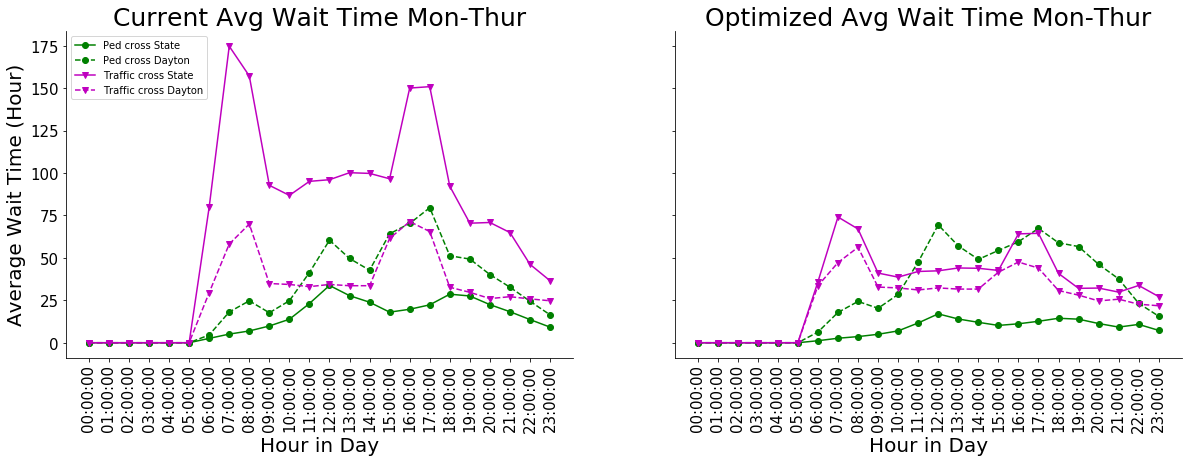

In [90]:
plot_wt_pat(dayton_wait_wkd_changed, tap_dayton_wait_wkd, "Current Avg Wait Time Mon-Thur", "Optimized Avg Wait Time Mon-Thur")

In [97]:
def plot_anger_pat(df_Hour, title, title2, 
                   df_ped_total_wait_main, df_ped_total_wait_cross, df_traffic_total_wait_main, df_traffic_total_wait_cross, 
                   pat_ped_total_wait_main, pat_ped_total_wait_cross, pat_traffic_total_wait_main, pat_traffic_total_wait_cross):
    fig, axes = plt.subplots(ncols=2, figsize=(20,6), sharex=True, sharey=True)
    
    ax2 = axes[0]
    ax2.plot(df_Hour, df_ped_total_wait_main, c='g',marker="o",ls='-', label='Ped cross State')
    ax2.plot(df_Hour, df_ped_total_wait_cross, c='g',marker="o",ls='--', label='Ped cross Dayton')
    ax2.plot(df_Hour, df_traffic_total_wait_main, c='m',marker="v",ls='-', label='Traffic cross State')
    ax2.plot(df_Hour, df_traffic_total_wait_cross, c='m',marker="v",ls='--', label='Traffic cross Dayton')
    ax2.set_title(title, fontsize=20)
    ax2.set_xticklabels(df_Hour, rotation=90)
    ax2.set_xlabel("Hour in Day", fontsize=20)
    ax2.set_ylabel("Anger Index", fontsize=20)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.legend(loc=2)
#     annot_max(df_Hour, df_total_wait_main, ax2)
    
    ax = axes[1]
    ax.plot(df_Hour, pat_ped_total_wait_main, c='g',marker="o",ls='-', label='Ped cross State')
    ax.plot(df_Hour, pat_ped_total_wait_cross, c='g',marker="o",ls='--', label='Ped cross Dayton')
    ax.plot(df_Hour, pat_traffic_total_wait_main, c='m',marker="v",ls='-', label='Traffic cross State')
    ax.plot(df_Hour, pat_traffic_total_wait_cross, c='m',marker="v",ls='--', label='Traffic cross Dayton')
    ax.set_title(title2, fontsize=20)
    ax.set_xticklabels(df_Hour, rotation=90)
    ax.set_xlabel("Hour in Day", fontsize=20)
#     ax.set_ylabel("Anger Index", fontsize=16)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
#     annot_max(df_Hour, df_total_wait_cross, ax)

In [94]:
def anger_index(x):
    return 1/3000*np.power(x, 2)
def anger_index_traffic(x):
    return 1/10000*np.power(x, 2)

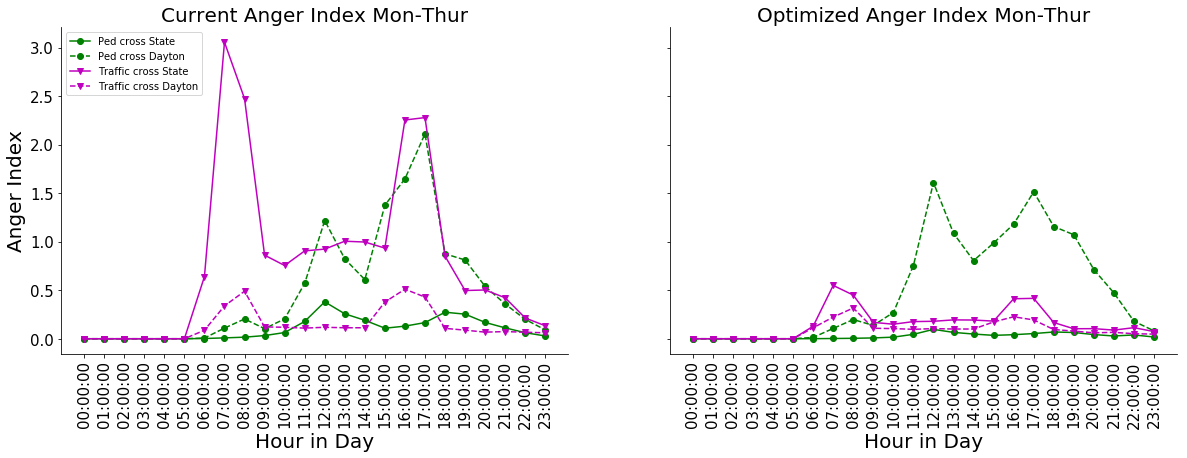

In [98]:
plot_anger_pat(dayton_wait_wkd.Hour, "Current Anger Index Mon-Thur", "Optimized Anger Index Mon-Thur", 
            anger_index(dayton_wait_wkd_changed.ped_total_wt_main_hour), anger_index(dayton_wait_wkd_changed.ped_total_wt_cross_hour), 
            anger_index_traffic(dayton_wait_wkd_changed.traffic_total_wait_main), anger_index_traffic(dayton_wait_wkd_changed.traffic_total_wait_cross),
            anger_index(tap_dayton_wait_wkd.ped_total_wt_main_hour), anger_index(tap_dayton_wait_wkd.ped_total_wt_cross_hour),
            anger_index_traffic(tap_dayton_wait_wkd.traffic_total_wait_main), anger_index_traffic(tap_dayton_wait_wkd.traffic_total_wait_cross),   
            )

The new pattern is optimized using the cost function based on anger index. We can see the overall anger index is decreasing. 

## Summary

In [110]:
dayton_wait_wkd_changed.tail()

,Count,Pattern,Hour,Total Cycle Time (s),Main Street Red (s),Main Street Yellow (s),Main Street Green (s),Main Street Total Cycle Time (s),Cross Street Red (s),Cross Street Yellow (s),...,ped_total_wait_main,ped_total_wait_cross,traffic_total_wait_main,traffic_total_wait_cross,traffic_avg_wait_main,traffic_avg_wait_cross,ped_total_wt_main_hour,ped_total_wt_cross_hour,traffic_total_wt_main_hour,traffic_total_wt_cross_hour
19,108295,6,19:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,99189.889615,177570.478462,70.461562,29.722153,0.0,0.0,27.552747,49.325133,0.019573,0.008256
20,88262,6,20:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,80841.202615,144722.522462,70.875000,26.021458,0.0,0.0,22.455890,40.200701,0.019688,0.007228
21,71878,6,21:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,65834.718923,117857.803692,64.949063,27.131667,0.0,0.0,18.287422,32.738279,0.018041,0.007537
22,53681,6,22:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,49167.666692,88020.322769,46.206563,25.836424,0.0,0.0,13.657685,24.450090,0.012835,0.007177
23,36138,6,23:00:00,65.0,31.5,3.0,30.5,35.0,36.5,3.0,...,33099.628154,59255.200615,36.559688,24.726215,0.0,0.0,9.194341,16.459778,0.010155,0.006868


In [109]:
tap_dayton_wait_wkd.tail()

,Count,Pattern,Hour,Total Cycle Time (s),Main Street Red (s),Main Street Yellow (s),Main Street Green (s),Main Street Total Cycle Time (s),Cross Street Red (s),Cross Street Yellow (s),...,ped_total_wait_main,ped_total_wait_cross,traffic_total_wait_main,traffic_total_wait_cross,traffic_avg_wait_main,traffic_avg_wait_cross,ped_total_wt_main_hour,ped_total_wt_cross_hour,traffic_total_wt_main_hour,traffic_total_wt_cross_hour
19,108295,6,19:00:00,52.0,20.0,3.0,29.0,33.5,35.0,3.0,...,49982.307692,204094.423077,32.055556,28.048611,0.0,0.0,13.883974,56.692895,0.008904,0.007791
20,88262,6,20:00:00,52.0,20.0,3.0,29.0,33.5,35.0,3.0,...,40736.307692,166339.923077,32.222222,24.645833,0.0,0.0,11.315641,46.205534,0.008951,0.006846
21,71878,6,21:00:00,52.0,20.0,3.0,29.0,33.5,35.0,3.0,...,33174.461538,135462.384615,29.833333,25.666667,0.0,0.0,9.215128,37.628440,0.008287,0.007130
22,53681,6,22:00:00,56.0,26.0,3.0,27.0,31.5,33.0,3.0,...,38880.381429,83512.298571,33.749444,22.701250,0.0,0.0,10.800106,23.197861,0.009375,0.006306
23,36138,6,23:00:00,56.0,26.0,3.0,27.0,31.5,33.0,3.0,...,26174.237143,56220.402857,27.177222,21.793750,0.0,0.0,7.270621,15.616779,0.007549,0.006054


In [125]:
def calc_saveWT_pat(df, opt):
    opt["ped_save_hour"] = (df["ped_total_wt_main_hour"] + df["ped_total_wt_cross_hour"]) \
                                  - (opt["ped_total_wt_main_hour"] + opt["ped_total_wt_main_hour"]) 
    opt["ped_save_pct"] = opt["ped_save_hour"] / (df["ped_total_wt_main_hour"] + df["ped_total_wt_cross_hour"])*100
    
    opt["traffic_save_hour"] = (df["traffic_total_wait_main"] + df["traffic_total_wait_cross"]) \
                                  - (opt["traffic_total_wait_main"] + opt["traffic_total_wait_main"]) 
    opt["traffic_save_pct"] = opt["traffic_save_hour"] / (df["traffic_total_wait_main"] + df["traffic_total_wait_cross"])*100
    
    opt["ped_save_pct"] = opt["ped_save_pct"].fillna(0)
    opt["traffic_save_pct"] = opt["traffic_save_pct"].fillna(0)
    return opt

In [126]:
tap_dayton_wait_wkd = calc_saveWT_pat(dayton_wait_wkd_changed, tap_dayton_wait_wkd)

In [127]:
tap_dayton_wait_wkd[["ped_save_hour","ped_save_pct", "traffic_save_hour", "traffic_save_pct" ]]

,ped_save_hour,ped_save_pct,traffic_save_hour,traffic_save_pct
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000
6,4.791165,67.048826,37.729965,34.454153
7,17.912111,77.205718,84.729792,36.372208
8,24.429116,77.205718,93.126493,40.981990
9,17.582893,63.880444,45.579201,35.695113


In [128]:
tap_dayton_wait_wkd.ped_save_hour.sum()

689.3226871527648

In [131]:
tap_dayton_wait_wkd.traffic_total_wait_main.sum(), dayton_wait_wkd_changed.traffic_total_wait_main.sum()

(796.26, 1761.9525)

In [132]:
tap_dayton_wait_wkd["ped_total_wt_main_hour"].sum(), dayton_wait_wkd_changed["ped_total_wt_main_hour"].sum()

(174.9374035523569, 326.6127627403846)

The following is just a projection

In [144]:
opt_des = pd.DataFrame({
    'cur_ped':[326.613, 418.718, 575.01], 
    'opt_ped':[174.937, 224.269, 307.877], 
    'cur_traffic':[352.2, 493.08, 529.18], 
    'opt_traffic':[159.2, 175.48, 238.8], 
}, index=['Dayton', 'Johnson', 'Gorham'])

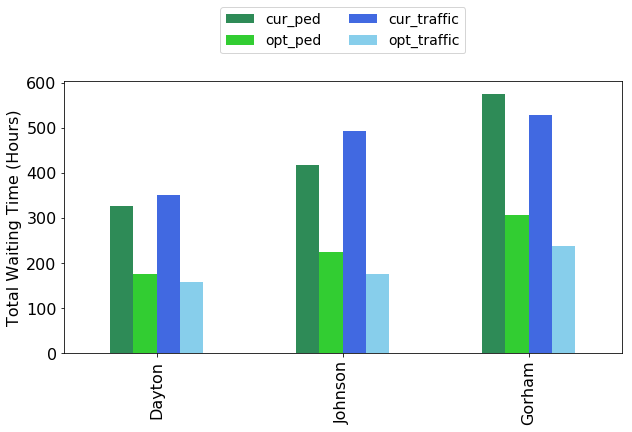

In [151]:
fig, ax = plt.subplots(figsize=(10,5))
opt_des.plot.bar(ax=ax, color = ['#2e8b57', '#32cd32', "#4169e1", "#87ceeb"])
ax.set_ylabel("Total Waiting Time (Hours)", fontsize=16)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)